# [《100天成为风控专家》](https://app7hmmvkwr2019.h5.xiaoeknow.com/p/course/ecourse/course_2ZAoFMNREbOv3DutKsoIi9Vlfky) 规则篇-规则生成(3)-决策树Python代码实操

In [102]:
import pandas as pd
import numpy as np
import scorecardpy as sc
from sklearn import tree
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import pydotplus
import graphviz
import seaborn as sns
from matplotlib import pyplot as plt
import os, re
%matplotlib inline
## 设置属性防止中文乱码
plt.rcParams['font.sans-serif'] = [u'SimHei']
plt.rcParams['axes.unicode_minus'] = False

import warnings
warnings.filterwarnings("ignore")

# 0.前期准备
- 第一步：安装GraphViz软件，https://graphviz.org/download/
- 第二步：安装graphviz： pip install graphviz
- 第三步：安装pydotplus: pip install pydotplus

# 1.数据探索

In [103]:
df = pd.read_csv('lending_club_loan_two.csv')
df.shape

(396030, 27)

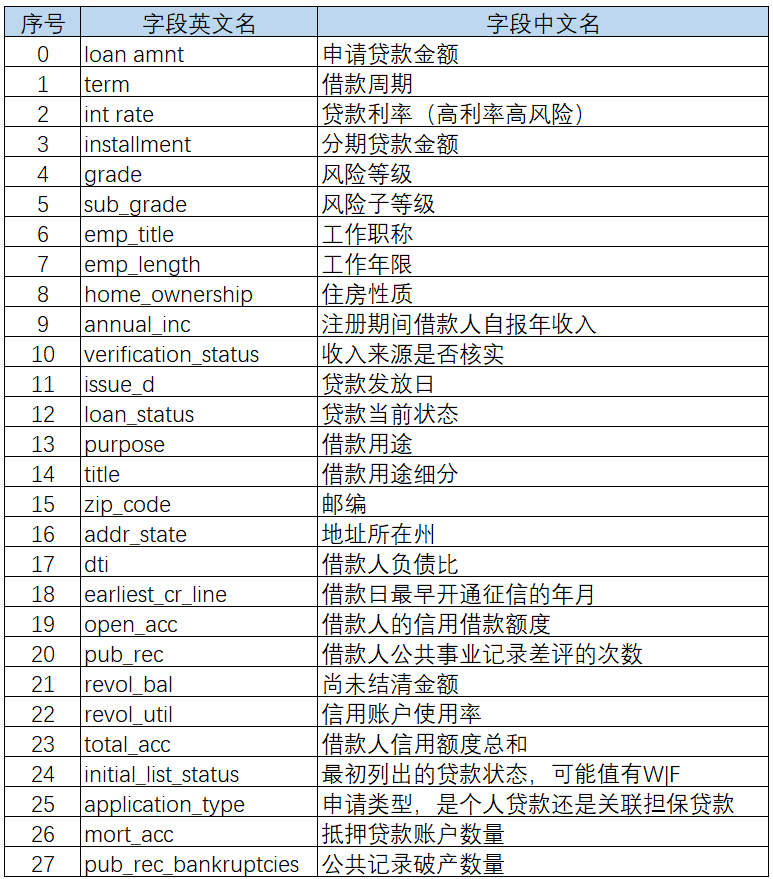

In [104]:
df.describe()

loan_amnt       int_rate    installment    annual_inc   
count  396030.000000  396030.000000  396030.000000  3.960300e+05  \
mean    14113.888089      13.639400     431.849698  7.420318e+04   
std      8357.441341       4.472157     250.727790  6.163762e+04   
min       500.000000       5.320000      16.080000  0.000000e+00   
25%      8000.000000      10.490000     250.330000  4.500000e+04   
50%     12000.000000      13.330000     375.430000  6.400000e+04   
75%     20000.000000      16.490000     567.300000  9.000000e+04   
max     40000.000000      30.990000    1533.810000  8.706582e+06   

                 dti       open_acc        pub_rec     revol_bal   
count  396030.000000  396030.000000  396030.000000  3.960300e+05  \
mean       17.379514      11.311153       0.178191  1.584454e+04   
std        18.019092       5.137649       0.530671  2.059184e+04   
min         0.000000       0.000000       0.000000  0.000000e+00   
25%        11.280000       8.000000       0.000000  6.025000e+03   
50%        16.910000      10.000000       0.000000  1.118100e+04   
75%        22.980000      14.000000       0.000000  1.962000e+04   
max      9999.000000      90.000000      86.000000  1.743266e+06   

          revol_util      total_acc       mort_acc  pub_rec_bankruptcies  
count  395754.000000  396030.000000  358235.000000         395495.000000  
mean       53.791749      25.414744       1.813991              0.121648  
std        24.452193      11.886991       2.147930              0.356174  
min         0.000000       2.000000       0.000000              0.000000  
25%        35.800000      17.000000       0.000000              0.000000  
50%        54.800000      24.000000       1.000000              0.000000  
75%        72.900000      32.000000       3.000000              0.000000  
max       892.300000     151.000000      34.000000              8.000000

In [105]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 396030 entries, 0 to 396029
Data columns (total 27 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   loan_amnt             396030 non-null  float64
 1   term                  396030 non-null  object 
 2   int_rate              396030 non-null  float64
 3   installment           396030 non-null  float64
 4   grade                 396030 non-null  object 
 5   sub_grade             396030 non-null  object 
 6   emp_title             373103 non-null  object 
 7   emp_length            377729 non-null  object 
 8   home_ownership        396030 non-null  object 
 9   annual_inc            396030 non-null  float64
 10  verification_status   396030 non-null  object 
 11  issue_d               396030 non-null  object 
 12  loan_status           396030 non-null  object 
 13  purpose               396030 non-null  object 
 14  title                 394274 non-null  object 
 15  

In [106]:
def simple_statics(df):
    # 读入数据
    stats = []
    for col in df.columns:
        stats.append((col, df[col].nunique(), 
                      (df[col].isnull()).sum() * 100 / df.shape[0],
                      df[col].value_counts(normalize=True, dropna=False).values[0] * 100, 
                      df[col].dtype))

    stats_df = pd.DataFrame(stats, columns=['Feature', 'Unique_values', 'Percentage_of_null',
                                            'Percentage_of_mode', 'Type'])
    stats_df.sort_values('Unique_values', ascending=False, inplace=True)
    return stats_df

In [107]:
sts_df = simple_statics(df)
sts_df.sort_values(by=['Percentage_of_null'],ascending=False)

Feature  Unique_values  Percentage_of_null   
24              mort_acc             33            9.543469  \
6              emp_title         173105            5.789208   
7             emp_length             11            4.621115   
14                 title          48816            0.443401   
25  pub_rec_bankruptcies              9            0.135091   
20            revol_util           1226            0.069692   
26               address         393700            0.000000   
12           loan_status              2            0.000000   
1                   term              2            0.000000   
10   verification_status              3            0.000000   
23      application_type              3            0.000000   
8         home_ownership              6            0.000000   
4                  grade              7            0.000000   
13               purpose             14            0.000000   
18               pub_rec             20            0.000000   
17              open_acc             61            0.000000   
5              sub_grade             35            0.000000   
11               issue_d            115            0.000000   
21             total_acc            118            0.000000   
2               int_rate            566            0.000000   
16      earliest_cr_line            684            0.000000   
0              loan_amnt           1397            0.000000   
15                   dti           4262            0.000000   
9             annual_inc          27197            0.000000   
19             revol_bal          55622            0.000000   
3            installment          55706            0.000000   
22   initial_list_status              2            0.000000   

    Percentage_of_mode     Type  
24           35.294548  float64  
6             5.789208   object  
7            31.826124   object  
14           38.500114   object  
25           88.473095  float64  
20            0.558796  float64  
26            0.002020   object  
12           80.387092   object  
1            76.258112   object  
10           35.240512   object  
23           99.820468   object  
8            50.084085   object  
4            29.295255   object  
13           59.214453   object  
18           85.415751  float64  
17            9.286923  float64  
5             6.730551   object  
11            3.748706   object  
21            3.605787  float64  
2             3.133853  float64  
16            0.761811   object  
0             6.986339  float64  
15            0.079034  float64  
9             3.866626  float64  
19            0.537333  float64  
3             0.244426  float64  
22           60.113123   object

## 1.1.目标变量

<Axes: xlabel='loan_status'>

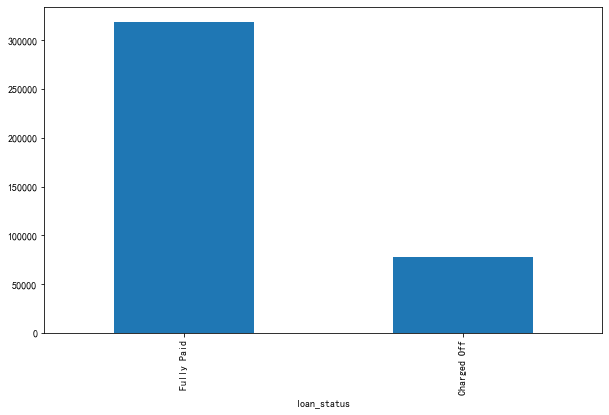

In [108]:
# 目标变量
yflag = 'loan_status'
plt.figure(figsize=(10,6))
df['loan_status'].value_counts(dropna=False).plot.bar()

In [109]:
df['loan_status'] = df['loan_status'].map({'Fully Paid':0,'Charged Off':1})
df['loan_status'].value_counts(dropna=False,normalize=True)

loan_status
0    0.803871
1    0.196129
Name: proportion, dtype: float64

In [110]:
col = df.columns.difference([yflag,'issue_d','address','emp_title','earliest_cr_line','title'])
# 筛选float和int的数值类型变量
num_list = df[col].select_dtypes(include=['float','int64']).columns.tolist()
# 筛选ojbect字符型的数值类型变量
obj_list = df[col].select_dtypes(include=['object']).columns.tolist()
print('数值类型变量共',len(num_list))
print('object类型变量共',len(obj_list))

数值类型变量共 12
object类型变量共 9


In [111]:
df[obj_list].head()

application_type emp_length grade home_ownership initial_list_status   
0       INDIVIDUAL  10+ years     B           RENT                   w  \
1       INDIVIDUAL    4 years     B       MORTGAGE                   f   
2       INDIVIDUAL   < 1 year     B           RENT                   f   
3       INDIVIDUAL    6 years     A           RENT                   f   
4       INDIVIDUAL    9 years     C       MORTGAGE                   f   

              purpose sub_grade        term verification_status  
0            vacation        B4   36 months        Not Verified  
1  debt_consolidation        B5   36 months        Not Verified  
2         credit_card        B3   36 months     Source Verified  
3         credit_card        A2   36 months        Not Verified  
4         credit_card        C5   60 months            Verified

## 1.2.对离散特征编码

In [112]:
for c in obj_list:
    le = LabelEncoder()
    le.fit(df[c])
    df[c] = le.transform(df[c])

In [113]:
# 对缺失值填充
df = df.fillna(-9999)

# 2.决策生成规则

DecisionTreeClassifier参数介绍：

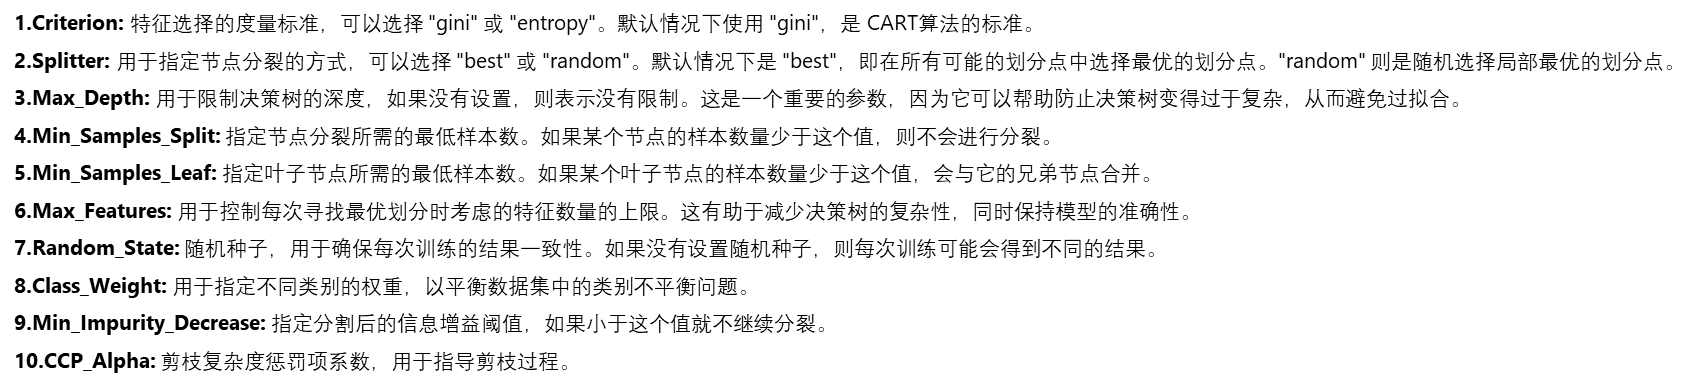

## 2.1.构建决策树模型

In [114]:
X = df[df.columns.difference([yflag,'issue_d','address','emp_title','earliest_cr_line','title'])]
y = df[yflag]

# 划分数据集
x_train,x_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)

# 按照最优的方式分裂
model=tree.DecisionTreeClassifier(criterion="gini",
                                  splitter='best',
                                  random_state=42,
                                  max_depth=3,
                                  min_samples_leaf=0.05,
                                  min_samples_split=0.05)
model = model.fit(x_train,y_train)

## 2.2.决策树可视化

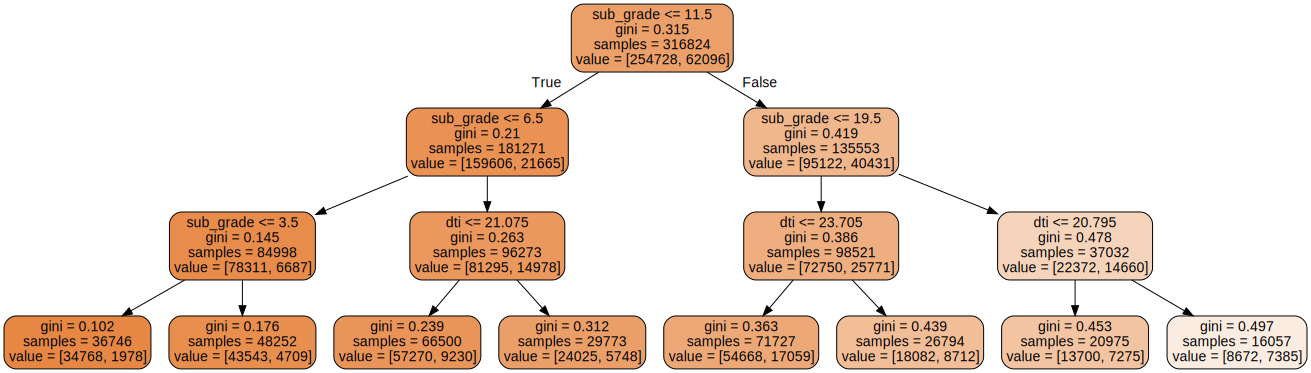

In [115]:
dot_data=tree.export_graphviz(model,
                              feature_names=X.columns,
                              filled=True,
                              rounded=True,
                              out_file=None)
graph=graphviz.Source(dot_data)
graph

## 2.3.决策树可视化的优化

对决策树的node节点信息通过正则表达式加工，自定义出规则的评估指标。

In [116]:
def original_tree_dot_file(graphviz_path: str, file_path: str, x: pd.DataFrame, tree_model):
    """
    基于sklearn中的tree.export_graphviz模块将决策树模型转换成dot文件（str)
    """
    os.environ["PATH"] += os.pathsep + graphviz_path # 时候python仍然找不到graphviz

    # 保存dot模型
    # with open(file_path + r'\tree.dot', 'w') as f:
    #     f = tree.export_graphviz(tree_model, out_file=f)

    dot_data = tree.export_graphviz(tree_model,
        out_file=None,
        feature_names=list(x),
        class_names=['bad', 'good'],
        filled=True,                                    # 绘制节点以指示分类的多数类、回归值的极值或多输出的节点纯度
        rounded=True,                                   # 设置为True时，使用圆角绘制节点框，并使用Helvetica字体而不是Times Roman。
        special_characters=True)                        # 设置为False时，忽略特殊字符以实现PostScript兼容性。
    return dot_data

In [117]:
def dot_adjust(dot_data: str, samples_amt: int, total_bad: int, pos=1,
               rule_criterion={'bad_rate_criterion': 0.18, 'reject_rate_criterion': 0.0001}):
    """
    将原始的dot文件相关内容修改成风控规则需要的指标
    """
    lines = dot_data.split('] ;')

    dot_new = ''
    for item in lines:
        # print(item)
        item = item + '] '
        samples = re.findall(r"(?<=samples\ \=\ ).*?(?=\<)", item)
        value = re.findall(r"(?<=value\ \=\ ).*?(?=\<)", item)
        item = re.sub(r'(?<=fillcolor=").*?(?=")', 'white', item)

        if len(samples) > 0 and len(value) > 0:
            samples = int(samples[0])
            value = value[0][1:-1]
            value_lst = value.split(',')
            goon_n = value_lst[pos]
            bad_n = samples - int(goon_n)
            bad_rate = bad_n / samples
            reject_rate = samples / samples_amt
            recall_rate = bad_n / total_bad

            if bad_rate >= rule_criterion['bad_rate_criterion'] and reject_rate >= rule_criterion[
                'reject_rate_criterion']:
                item = re.sub(r'(?<=fillcolor=").*?(?=")', 'orange', item)

            item = re.sub(r'(?<=gini\ \=\ )\d+(\.\d+)?', str(round(bad_rate * 100, 2)) + '%', item)
            item = item.replace('gini', 'bad_rate')

            item = re.sub(r'(?<=class\ \=\ ).*?(?=\>)', str(round(reject_rate * 100, 2)) + '%', item)
            item = item.replace('>class', '>reject_rate')
            
            item = re.sub(r'>,', '<br/>recall_rate = ' + str(round(recall_rate * 100, 2)) + '%'+'>, ', item)
            
            dot_new += item + ';'
        else:
            dot_new += item
    dot_new = dot_new[:-1]
    return dot_new

In [118]:
def dot4pdf(graphviz_path: str, file_path: str, x: pd.DataFrame, y: pd.Series, rule_criterion: dict, tree_model, pos=1):
    """
    融合前面两个函数的功能，集成为一键生成的规则函数
    """
    total_bad = y.sum()
    ori_dot = original_tree_dot_file(graphviz_path, file_path, x, tree_model)
    new_dot = dot_adjust(ori_dot, len(x), total_bad, pos, rule_criterion)
    graph_new = pydotplus.graph_from_dot_data(new_dot)

    # 保存图像到pdf文件
    graph_new.write_pdf(file_path + r'\rule_tree_graph.pdf')

In [119]:
os.getcwd()

'C:\\Users\\yaodyu\\风控\\100天成为风控专家\\规则生成-决策树'

In [120]:
# 定义要要输出的文件路径
file_path = r'C:\\Users\\yaodyu\\风控\\100天成为风控专家\\规则生成-决策树'
# 定义graphviz包的路径
graphviz_path = r'd:\anaconda\envs\mylearning\lib\site-packages\graphviz'

# 定义规则的评估标准
bad_rate_criterion = y.sum() / len(df)
rule_criterion = {'bad_rate_criterion': 1.5*bad_rate_criterion, 'reject_rate_criterion': 0.01}

# 执行可视化
dot4pdf(graphviz_path, file_path, X, y, rule_criterion, model, pos=0)

## 2.4. 制定规则

**规则：(sub_grade>19.5)&(dti>20.795)**

评估指标：
- badrate=45.99%
- lift=39.02%/19.61%=2.34
- hitrate=4.05%
- recall_rate=9.51%

# 番外

如果对pandas不熟悉想要进阶的朋友可以了解下东哥的这个原创笔记，已经完全体，后续随着版本迭代会持续更新。

[《pandas进阶宝典》](https://app7hmmvkwr2019.h5.xiaoeknow.com/p/course/ecourse/course_2YD5u0x8FzrAIyM8soEuxnTkP9r)永久访问权限，500页图文笔记，近30万字，配套完整代码支持下载。

5大核心图文，具体包括：
- 《pandas快速入门》
- 《pandas进阶宝典》
- 《pandas实战项目》
- 《pandas进阶题库》
- 《Numpy速查手册》
- 《正则表达式手册》

感兴趣可以扫码了解，或者加我微信可以有折扣，加V：`Petery_1966`

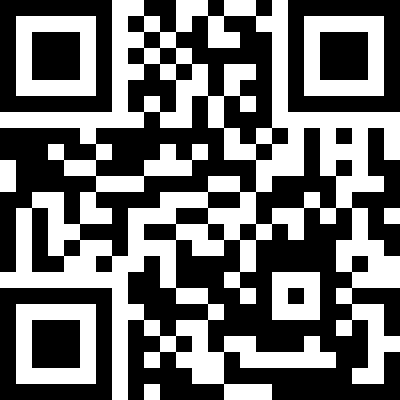